# **Lane Lines Detection** 
***

In this project, we'll be identifying lane lines on the road. Imagine cruising down the highway, your car autonomously navigating thanks to your expert lane detection skills! Pretty neat, right?

First things first, we'll start with individual images, perfecting our lane line detective skills before hitting the big leagues with a video stream (which, technically, is just a fancy way of saying lots of images stitched together). Check out the video "raw-lines-example.mp4" to see what our final product should look like after using the handy helper functions we'll have at our disposal.

Once we've got something resembling "raw-lines-example.mp4", it's time to unleash our inner creative genius! We'll need to combine and extend those detected lane segments, painting a broader picture of the full lane lines. The video "P1_example.mp4" gives a glimpse of what we're aiming for – imagine having just one clean line for each side of the lane, guiding our virtual car to safety.

So, are you ready to roll? Let's put our lane line detection skills to the test and see what amazing things we can create!

---
Alright, let's dive into our first image! It's called "test_images/solidWhiteRight.jpg" and holds the key to unlocking our lane line detection secrets. Go ahead and hit Shift-Enter or click the "play" button up top to bring it to life.

(Remember, if things ever get glitchy or confusing, don't hesitate to hit that "Kernel" menu and select "Restart & Clear Output" for a fresh start.)

Now that we have our image displayed, it's time to start analyzing it, piecing together the puzzle of those elusive lane lines. Stay tuned, the adventure awaits!

---

The tools that we're going to use are as follows:
* Color Selection 
* Region of interest Selection 
* Grayscaling 
* Gaussian Smoothing 
* Canny Edge Detection 
* Hough Tranform   

Our goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below). Once we have a working pipeline, we will try it out on the video stream below.

---

<figure>
 <img src="output_images/samples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Our output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="output_images/samples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Our goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Importing Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Reading in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


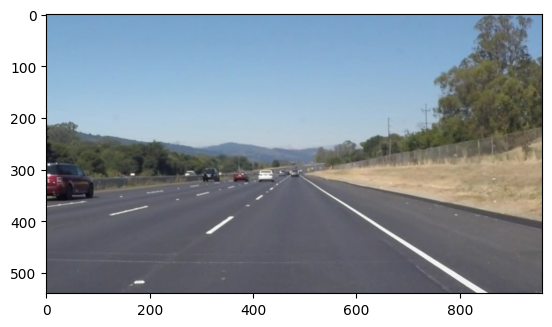

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions that might be useful for this project are given as:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**We can always check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

In [3]:
import math

# Function 1: Convert image to grayscale
def grayscale(img):
    """
    Converts the input image to grayscale.
    Args:
        img: The input image (assumed to be RGB or BGR).
    Returns:
        The grayscale image as a NumPy array.
    """

    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Use BGR2GRAY if image was read with cv2.imread()

# Function 2: Apply Canny edge detection
def canny(img, low_threshold, high_threshold):
    """
    Applies the Canny edge detection algorithm to the image.
    Args:
        img: The input image (grayscale).
        low_threshold: The lower threshold for edge detection.
        high_threshold: The higher threshold for edge detection.
    Returns:
        The image with edges marked in white.
    """

    return cv2.Canny(img, low_threshold, high_threshold)

# Function 3: Apply Gaussian blur
def gaussian_blur(img, kernel_size):
    """
    Applies a Gaussian blur to the image to reduce noise.
    Args:
        img: The input image.
        kernel_size: The size of the Gaussian kernel (tuple of width and height).
    Returns:
        The blurred image.
    """

    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Function 4: Apply an image mask
def region_of_interest(img, vertices):
    """
    Applies a mask to the image, keeping only the region of interest defined by the vertices.
    Args:
        img: The input image.
        vertices: A NumPy array of integer points defining the vertices of the polygonal mask.
    Returns:
        The masked image.
    """

    # Create a blank mask with the same dimensions as the image
    mask = np.zeros_like(img)

    # #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    # if len(img.shape) > 2:
    #     channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
    #     ignore_mask_color = (255,) * channel_count
    # else:
    #     ignore_mask_color = 255

    # Fill the mask with white color inside the polygon defined by vertices
    cv2.fillPoly(mask, vertices, 255)

    # Apply the mask to the image
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
        

        
# Function 7: Overlay lines on the original image
def draw_lines(img, lines, color=[180, 90, 245], thickness=8):
    """
    Draws lines on an image with specified color and thickness.
    Modifies the image in-place.
    Consider combining with weighted_img() for semi-transparent lines.
    """

    # ---- Separate lines based on slope and create lane line endpoints ----

    x_left_lane = []
    y_left_lane = []
    x_right_lane = []
    y_right_lane = []

    # Fixed y-coordinates for top and bottom of lanes
    ytop = int(350)
    ybtm = int(540)

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = float(((y2 - y1) / (x2 - x1)))

            if slope > 0.3:  # Left lane (positive slope)
                x_left_lane.extend([x1, x2])
                y_left_lane.extend([y1, y2])

            elif slope < -0.3:  # Right lane (negative slope)
                x_right_lane.extend([x1, x2])
                y_right_lane.extend([y1, y2])

    # ---- Draw lane lines if points were found ----

    if (x_left_lane and x_right_lane and y_left_lane and y_right_lane):

        # Left lane
        left_line_coeffs = np.polyfit(x_left_lane, y_left_lane, 1)  # Fit a line to the left lane points
        left_xtop = int((ytop - left_line_coeffs[1]) / left_line_coeffs[0])  # Calculate top endpoint
        left_xbtm = int((ybtm - left_line_coeffs[1]) / left_line_coeffs[0])  # Calculate bottom endpoint
        cv2.line(img, (left_xtop, ytop), (left_xbtm, ybtm), color, thickness)  # Draw the line

        # Right lane
        right_line_coeffs = np.polyfit(x_right_lane, y_right_lane, 1)  # Fit a line to the right lane points
        right_xtop = int((ytop - right_line_coeffs[1]) / right_line_coeffs[0])  # Calculate top endpoint
        right_xbtm = int((ybtm - right_line_coeffs[1]) / right_line_coeffs[0])  # Calculate bottom endpoint
        cv2.line(img, (right_xtop, ytop), (right_xbtm, ybtm), color, thickness)  # Draw the line

# Function 6: Apply Hough line transform
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Applies the Hough line transform to the image.
    Args:
        img: The input image (assumed to be the output of a Canny transform).
        rho: The distance resolution in pixels of the Hough grid.
        theta: The angle resolution in radians of the Hough grid.
        threshold: The minimum number of votes (intersections in Hough grid cell) for a line to be considered.
        min_line_len: The minimum length of a line.
        max_line_gap: The maximum gap between two points to be considered part of the same line.
    Returns:
        An image with detected lines drawn on it.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

# Function 7: Overlay lines on the original image
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now let's build our pipeline to work on the images in the directory "test_images"  
**We should make sure that our pipeline works well on these images before trying the videos.**

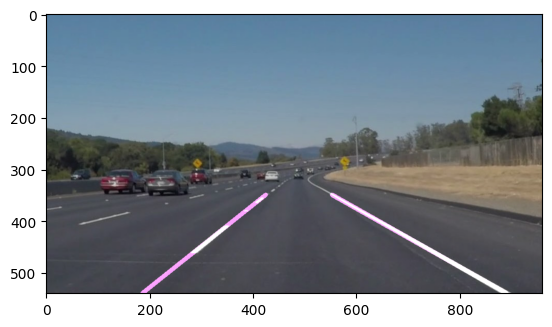

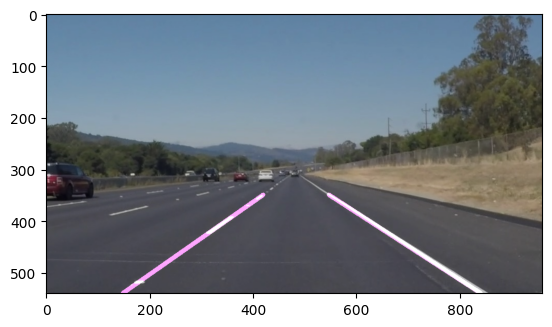

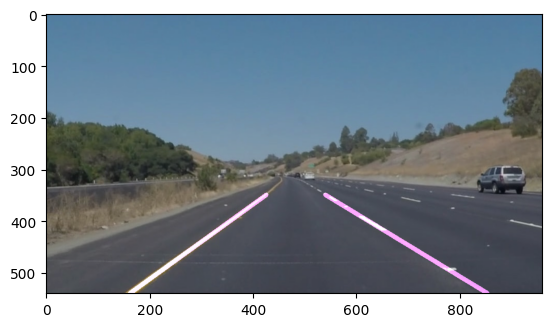

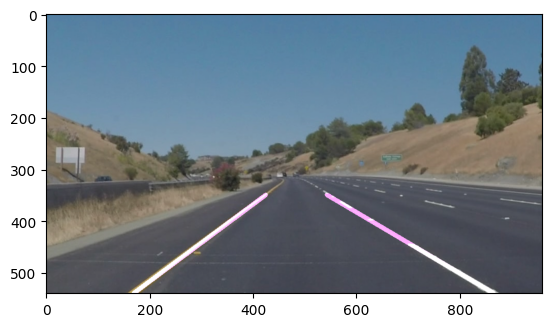

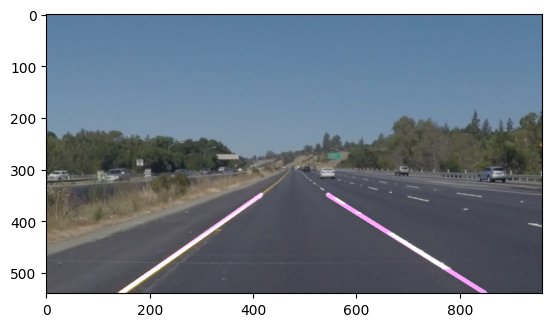

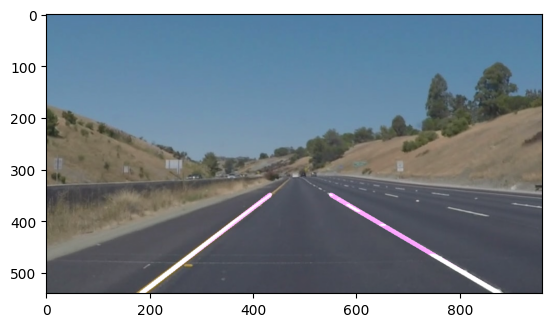

In [4]:
import os

# Get a list of test image filenames
test_cases = os.listdir("test_images/")

import matplotlib.image as mpimg
import numpy as np  # Import numpy for array operations

# Function to process an image and detect lane lines
def heart_lanelines(image):
    """
    Applies a series of image processing techniques to detect lane lines in an image.
    Args:
        image: The input image.
    Returns:
        The processed image with detected lane lines overlaid.
    """

    # Convert image to grayscale
    gray_scaled_image = grayscale(image)

    # Apply Gaussian blur to reduce noise
    kernal_size = 7  # Use a kernel size of 7 for blurring
    blur_gray = gaussian_blur(gray_scaled_image, kernal_size)

    # Define the region of interest (ROI) for lane line detection
    vertices = np.array([[
        (135, 540),  # Top-left corner of ROI
        (960, 540),  # Top-right corner of ROI
        (540, 335),  # Bottom-right corner of ROI
        (435, 335)   # Bottom-left corner of ROI
    ]])

    # Apply Canny edge detection to highlight edges
    low_threshold = 50  # Lower threshold for Canny edge detection
    high_threshold = 150  # Higher threshold for Canny edge detection
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Apply the ROI mask to focus on the relevant area
    region_fit = region_of_interest(edges, vertices)

    # Apply Hough transform to detect lines in the ROI
    rho = 1  # Distance resolution in pixels of the Hough grid
    theta = np.pi / 360  # Angular resolution in radians of the Hough grid
    threshold = 40  # Minimum number of votes for a line
    min_line_length = 100  # Minimum line length in pixels
    max_line_gap = 300  # Maximum gap between line segments
    lines = hough_lines(region_fit, rho, theta, threshold, min_line_length, max_line_gap)

    # Overlay the detected lines on the original image
    output_image = weighted_img(lines, image)

    return output_image

# Function to display an image and save it to a file
def display_image(image, count):
    """
    Displays an image and saves it to a file.
    Args:
        image: The image to display.
        count: A counter used for naming the output file.
    """
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.savefig(f"output_images/out{count}.jpg")

# Function to process a test image
def final_touchup(image_path, count):
    """
    Processes a test image and saves the processed output.
    Args:
        image_path: The path to the test image.
        count: A counter used for naming the output file.
    """
    image = mpimg.imread(image_path)
    processed_image = heart_lanelines(image)
    display_image(processed_image, count)

# Process each test image
count = 1
for image in test_cases:
    path = 'test_images/' + image
    final_touchup(path, count)
    count += 1


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import *
from IPython.display import HTML

In [6]:
def process_image(image):
    """
    Processes an image to detect lane lines and returns the processed image.
    Args:
        image: The input image to process.
    Returns:
        The processed image with lane lines overlaid.
    """
    return heart_lanelines(image)  # Calls a placeholder function for lane line detection

Let's try the one with the solid white lane on the right first ...

In [7]:
# Define the path for the output video file
white_output = 'output_videos/solidWhiteRight_output.mp4'

# Load the input video clip
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

# Apply the image processing pipeline to each frame of the video
white_clip = clip1.fl_image(process_image)
# **NOTE:** The `fl_image` function expects the `process_image` function to return color images (3 channels).

# Measure the processing time and write the processed video to a file
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video output_videos/solidWhiteRight_output.mp4.
Moviepy - Writing video output_videos/solidWhiteRight_output.mp4



Moviepy - Done !
Moviepy - video ready output_videos/solidWhiteRight_output.mp4
CPU times: user 4.91 s, sys: 2.68 s, total: 7.59 s
Wall time: 4.09 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the output_videos directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, we have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments we identified with the Hough Transform. Let's modify our draw_lines function accordingly and try re-running our pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
# Specify the output file path for the processed video
yellow_output = 'output_videos/solidYellowLeft_output.mp4'

# Load the input video clip from its source file
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

# Apply the image processing function to each frame and create a new clip
yellow_clip = clip2.fl_image(process_image)
    #  - `fl_image` applies the provided function to each frame of the clip.
    #  - It's essential that `process_image` returns color images (3 channels).

# Measure the processing time and write the processed clip to the output file
%time yellow_clip.write_videofile(yellow_output, audio=False)
    #  - The `%time` magic command in Jupyter Notebook measures execution time.
    #  - `write_videofile` saves the processed clip to a video file.

Moviepy - Building video output_videos/solidYellowLeft_output.mp4.
Moviepy - Writing video output_videos/solidYellowLeft_output.mp4



Moviepy - Done !
Moviepy - video ready output_videos/solidYellowLeft_output.mp4
CPU times: user 15 s, sys: 9.06 s, total: 24.1 s
Wall time: 12.3 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Passage Rephrasing: Unveiling the Lanes and Brainstorming Improvements
Our quest for lane lines has been fruitful! Now, as we stand at the project's culmination, I invite your valuable insights on our lane finding pipeline. How can we envision enhancing its efficiency and resilience? In other words, where might our current approach encounter stumbling blocks?

Share your thoughts freely below. If you're a problem-solving enthusiast, you'll find an optional challenge video waiting further down – an opportunity to truly strengthen our pipeline!

Here are some shortcomings that I found in my implementation:

* Sharp turns: The algorithm stumbles during turns, causing the lane lines to go haywire. This highlights the need for better handling of curved paths.

* Novice limitations: This is a preliminary algorithm, excelling on straight roads but lacking the complexity to navigate potholes. An image showcasing such challenging terrain would be invaluable for testing and improvement.

* Motion integration: Combining motion data with images through a Kalman filter is suggested to track lane changes more smoothly across consecutive frames.

Let's leverage this collective wisdom to refine our lane finding magic!

## Optional Challenge

Ready for a real-world test? Put your lane finding pipeline to the ultimate challenge with the video below. Can it still work its magic amidst the complexities of this new environment?

But the journey doesn't stop there! Are you the code-wielding hero to make your algorithm even stronger? Can you find ways to boost its resilience and adaptability?

If you're up for the adventure, dive into the code and modify your pipeline. Show it you mean business, and make it work seamlessly with this challenging video. Remember, the road to success (and smoother lane lines) is paved with innovation and perseverance!

So, buckle up, unleash your coding wizardry, and conquer this exciting challenge!

In [11]:
# Set the output path for the processed video:
challenge_output = 'output_videos/challenge_output.mp4'

# Load the challenging video clip:
clip2 = VideoFileClip('test_videos/challenge.mp4')

# Apply the lane finding pipeline to each frame:
challenge_clip = clip2.fl_image(process_image)
    # - `fl_image` applies the `process_image` function to every frame.
    # - Crucial: `process_image` must return color images (3 channels).

# Measure processing time and write the processed clip:
%time challenge_clip.write_videofile(challenge_output, audio=False)
    # - `%time` (Jupyter Notebook) measures execution time.
    # - `write_videofile` saves the processed clip to a file.

Moviepy - Building video output_videos/challenge_output.mp4.
Moviepy - Writing video output_videos/challenge_output.mp4



Moviepy - Done !
Moviepy - video ready output_videos/challenge_output.mp4
CPU times: user 9.66 s, sys: 4.05 s, total: 13.7 s
Wall time: 9.68 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))